## Breaking Captchas using Keras CNN

In [1]:
# Imports
import numpy as np
import os
import pickle

from keras.utils import np_utils
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Input, concatenate
from keras.layers.convolutional import Conv2D, Convolution2D, MaxPooling2D
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta
from matplotlib import pyplot as plt
from keras.models import model_from_json
from PIL import Image
import glob
import cv2

%matplotlib inline

/home/yan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from python_anticaptcha import AnticaptchaClient, ImageToTextTask
import urllib.request
import ssl

## Methods

In [3]:
# useful methods
def captcha_to_vec(captcha):    
    vector = np.zeros(word_len * word_class)
    
    for i,ch in enumerate(captcha):
        idex = i * word_class + char_indices[ch]
        vector[idex] = 1
    return vector

def vec_to_captcha(vec):
    text = []
    vec[vec < 0.5] = 0
        
    char_pos = vec.nonzero()[0]
    
    for i, ch in enumerate(char_pos):
        text.append(captcha_word[ch % word_class])
    return ''.join(text)

## Control Variables

In [4]:
download = 0
resize = 0
captcha = 0
api_key = '27872f336948e28bf905e61f192b9148'

## Codes

In [5]:
# download file
if (download == 1):
    
    ssl._create_default_https_context = ssl._create_unverified_context

    for i in range(0,900):
        url = 'https://siconfi.tesouro.gov.br/siconfi/imageCaptcha'
        urllib.request.urlretrieve(url, "mais_imagens/{}.png".format(i))

In [6]:
# resize img

if (resize == 1):
    
    train_dir_raw = r'/home/yan/jupyter notebooks/mais_imagens'
    train_dir_output = r'/home/yan/jupyter notebooks/imagens_novas_ready'


    for item in os.listdir(train_dir_raw):
        img_raw = Image.open(train_dir_raw + '/' + item)
        width, height = img_raw.size
        left = 5
        top = 5
        right = width*0.42
        bottom = height*0.9
        img_output = img_raw.crop((left, top, right, bottom))
        img_output.save(train_dir_output + '/' + item)

In [7]:
if (captcha == 1):
    
    path_input = r'/home/yan/jupyter notebooks/imagens_novas_ready/'
    path_output = '/home/yan/jupyter notebooks/output_imagens_vai/'

    for i in range(50, 200):
        print (i)
        image_path = path_input + '{}.png'.format(i)
        im = Image.open(image_path)       
        captcha_fp = open(image_path, 'rb')
        client = AnticaptchaClient(api_key)
        task = ImageToTextTask(captcha_fp)
        job = client.createTask(task)
        job.join()
        text_image = job.get_captcha_text()
        text_image = str.lower(text_image)
        im.save(path_output + '{}.png'.format(text_image))

In [8]:
train_dir = r'/home/yan/jupyter notebooks/todas_imagens_certo'

img_path = train_dir + '/' + '5mbww.png'

img = Image.open(img_path)
print (img.size)

(94, 40)


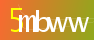

In [9]:
img

In [10]:
# parameters

captcha_word = "123456789abcdefghijklmnopqrstuvwxyz"

width = 94
height = 40


word_len = 5
word_class = len(captcha_word)


char_indices = dict((c, i) for i,c in enumerate(captcha_word))
indices_char = dict((i, c) for i,c in enumerate(captcha_word))

In [11]:
test_vec = captcha_to_vec("12345")
vec_test = vec_to_captcha(test_vec)

print(test_vec)
print(vec_test)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
12345


In [12]:
# get image names
image_list = []

i = 0
for item in os.listdir(train_dir):
    image_list.append(item)
    if (i > 1000):
        break
        
    i+=1
    
np.random.shuffle(image_list)
print (image_list[:10])

print (len(image_list))

['rnn2x.png', 'px7rm.png', '46mry.png', 'whxd8.png', 'nfmrn.png', 'p5y3r.png', '7dk33.png', '754rd.png', '2hb4c.png', 'ede5n.png']
1002


In [13]:
#load images
X = np.zeros((len(image_list), height, width, 3), dtype = np.uint8)
y = np.zeros((len(image_list), word_len * word_class), dtype = np.uint8)

for i,img in enumerate(image_list):
    if i % 100 == 0:
        print(i)
        
    img_path = train_dir + "/" + img
    raw_img = image.load_img(img_path, target_size=(height, width))
    X[i] = image.img_to_array(raw_img)
    y[i] = captcha_to_vec(img.split('.')[0])

0
100
200
300
400
500
600
700
800
900
1000


In [14]:
# Keras CNN (Convolutional Neural Network)
input_tensor = Input(shape=(height, width, 3))

x = input_tensor

x = Convolution2D(32, 3, padding='same', activation='relu')(x)
x = Convolution2D(32, 3, padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Convolution2D(32, 3, padding='same', activation='relu')(x)
x = Convolution2D(32, 3, padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Convolution2D(32, 3, padding='same', activation='relu')(x)
x = Convolution2D(32, 3, padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2))(x)


x = Flatten()(x)
x = Dropout(0.5)(x)


x = [Dense(word_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(word_len)]
output = concatenate(x)

In [15]:
# model
model = Model(inputs=input_tensor, outputs=output)

opt = Adadelta(lr=0.01)

model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [16]:
checkpointer = ModelCheckpoint(filepath='bestmodel.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

model.fit(X, y, epochs=50, callbacks=[checkpointer, earlystopper], validation_split=0.2)

Train on 801 samples, validate on 201 samples
Epoch 1/50
801/801 [==============================] - 12s 15ms/step - loss: 43.4909 - acc: 0.0050 - val_loss: 25.0777 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 25.07767, saving model to bestmodel.hdf5
Epoch 2/50
801/801 [==============================] - 12s 15ms/step - loss: 24.7631 - acc: 0.0025 - val_loss: 24.4619 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 25.07767 to 24.46194, saving model to bestmodel.hdf5
Epoch 3/50
801/801 [==============================] - 12s 15ms/step - loss: 24.1873 - acc: 0.0150 - val_loss: 24.1596 - val_acc: 0.0000e+00

Epoch 00003: val_loss improved from 24.46194 to 24.15958, saving model to bestmodel.hdf5
Epoch 4/50
801/801 [==============================] - 13s 16ms/step - loss: 24.0056 - acc: 0.0175 - val_loss: 23.9253 - val_acc: 0.0199

Epoch 00004: val_loss improved from 24.15958 to 23.92532, saving model to bestmodel.hdf5
Epoch 5/50
801/801 [=======================

801/801 [==============================] - 14s 17ms/step - loss: 9.1713 - acc: 0.4757 - val_loss: 18.6546 - val_acc: 0.3781

Epoch 00040: val_loss did not improve from 16.32688
Epoch 41/50
801/801 [==============================] - 14s 18ms/step - loss: 9.3108 - acc: 0.4257 - val_loss: 19.7434 - val_acc: 0.4428

Epoch 00041: val_loss did not improve from 16.32688
Epoch 42/50
801/801 [==============================] - 14s 18ms/step - loss: 9.2603 - acc: 0.4682 - val_loss: 16.7696 - val_acc: 0.5721

Epoch 00042: val_loss did not improve from 16.32688
Epoch 43/50
801/801 [==============================] - 20s 25ms/step - loss: 8.9622 - acc: 0.4694 - val_loss: 17.4886 - val_acc: 0.5721

Epoch 00043: val_loss did not improve from 16.32688
Epoch 44/50
801/801 [==============================] - 21s 27ms/step - loss: 8.9307 - acc: 0.4694 - val_loss: 19.3279 - val_acc: 0.4826

Epoch 00044: val_loss did not improve from 16.32688
Epoch 45/50
801/801 [==============================] - 18s 23ms/ste

In [17]:
# save model as json file
model_json = model.to_json()
with open("model_output/captcha_model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model_output/model_weights.h5")
print("Saved model to disk")

Saved model to disk


In [18]:
# load model from a json file
json_file = open('model_output/captcha_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_output/model_weights.h5")
print("Loaded model from disk")

Loaded model from disk


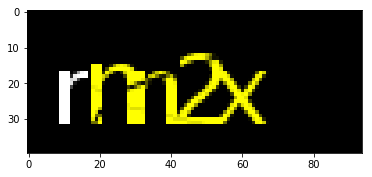

true: rnn2x | predicted: rnn2x


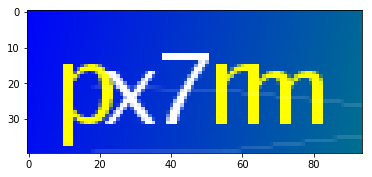

true: px7rm | predicted: px7rm


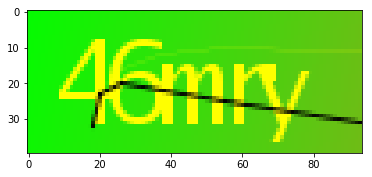

true: 46mry | predicted: 46mry


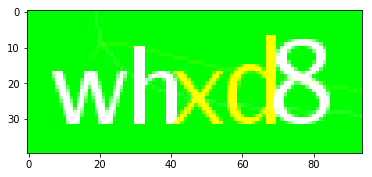

true: whxd8 | predicted: whxd8


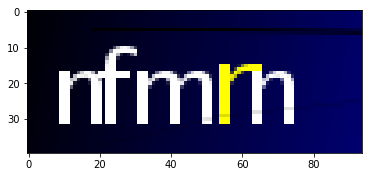

true: nfmrn | predicted: nfmrn


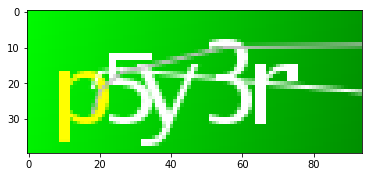

true: p5y3r | predicted: p5y3r


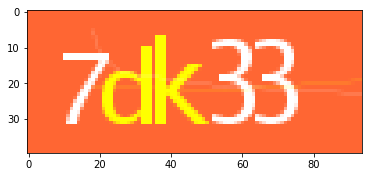

true: 7dk33 | predicted: 7dk33


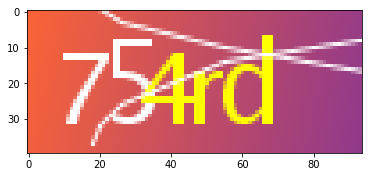

true: 754rd | predicted: 754rd


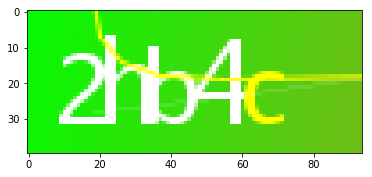

true: 2hb4c | predicted: 2hb4c


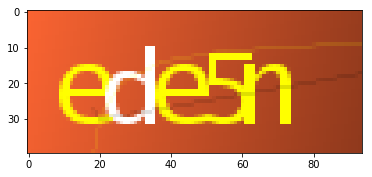

true: ede5n | predicted: ede5n


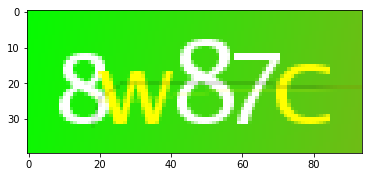

true: 8w87c | predicted: 8w87c


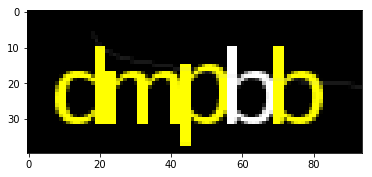

true: dmpbb | predicted: dmpbb


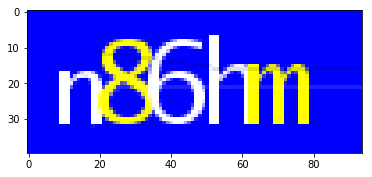

true: n86hm | predicted: n86hm


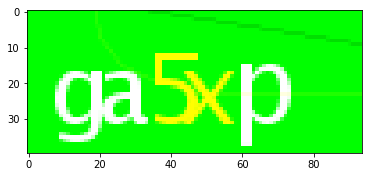

true: ga5xp | predicted: ga5xp


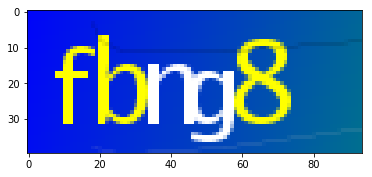

true: fbng8 | predicted: fbng8


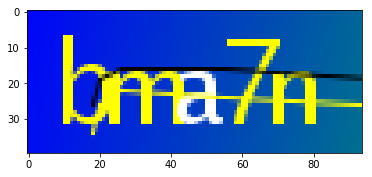

true: bma7n | predicted: bma7n


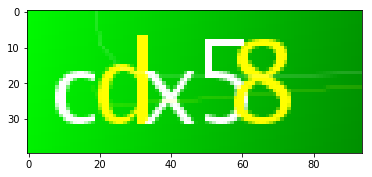

true: cdx58 | predicted: cdx58


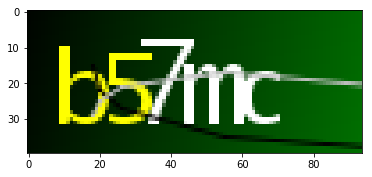

true: b57mc | predicted: b57mc


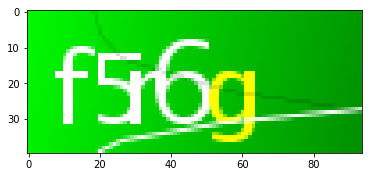

true: f5r6g | predicted: f5r6g


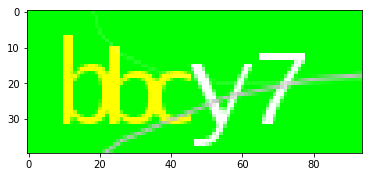

true: bbcy7 | predicted: bbcy7


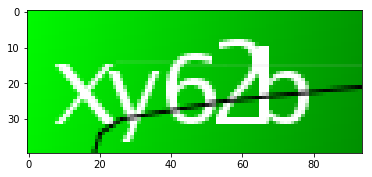

true: xy62 | predicted: xy62b


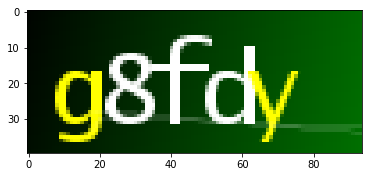

true: g8fdy | predicted: g8fdy


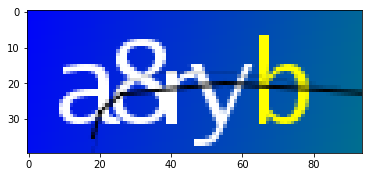

true: a8ryb | predicted: a8ryb


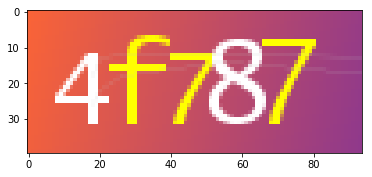

true: 4f787 | predicted: 4f787


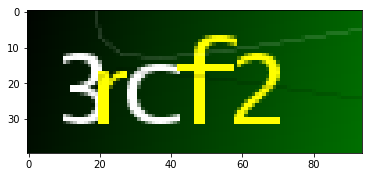

true: 3rcf2 | predicted: 3rcf2


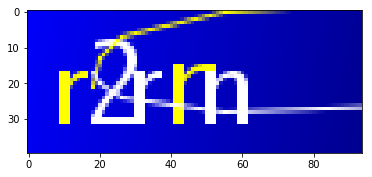

true: r2rrn | predicted: r2rrn


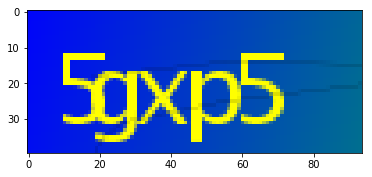

true: 5gxp5 | predicted: 5gxp5


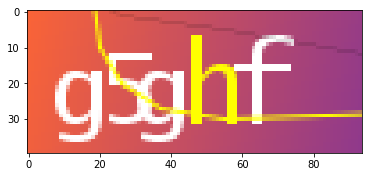

true: g5ghf | predicted: g5ghf


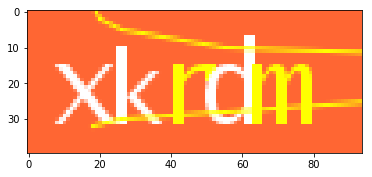

true: xkrdm | predicted: xkrdm


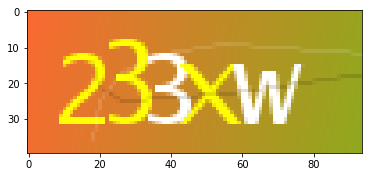

true: 233xw | predicted: 233xw


In [19]:
#show some results
def testCaptcha(index):
    raw_img = X[index]
    true_label = y[index]
    
    X_test = np.zeros((1, height, width, 3), dtype = np.float32)
    X_test[0] = image.img_to_array(raw_img)
    
    result = model.predict(X_test)
    
    vex_test = vec_to_captcha(result[0])
    true_test = vec_to_captcha(true_label)
    
    plt.imshow(raw_img)
    plt.show()
    
    print("true:",true_test,"| predicted:",vex_test)
    

for i in range(30):
    testCaptcha(i)

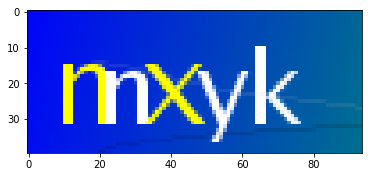

prediction: nnxyk


In [21]:
# single test
raw_img = image.load_img(train_dir + '/nnxyk.png', target_size=(height, width))

X_test = np.zeros((1, height, width, 3), dtype = np.float32)
X_test[0] = image.img_to_array(raw_img)
result = model.predict(X_test)

vex_test = vec_to_captcha(result[0])
plt.imshow(raw_img)
plt.show()

print ('prediction:', vex_test)